In [1]:
!pip install split-folders


#Import libraries


In [2]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import load_model  # For loading pre-trained models
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout  # For defining model layers
# Training callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping  # For training callbacks
# Pre-trained models
import numpy as np


In [3]:
import shutil

#Data preprocess(Load, normalize and augmnet the data)

In [4]:
#dawonload the data set
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:03<00:00, 188MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


#Split the data and create two folders for training and validation to prevent data leakage.



In [5]:
# Path to the folder containing images
path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2"
dataset_dir = os.path.join(path, "raw-img")  # Ensure this folder name is correct

# New output directory for split data
output_dir = os.path.join(path, "Animals10_Split")
# Delete existing split folders if they exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)


In [6]:

# Split the dataset into 80% training and 20% validation
splitfolders.ratio(
    dataset_dir,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.2),  # 80% training, 20% validation
    group_prefix=None,
    move=False  # Set to True if you want to move files instead of copying
)

# Define the new paths
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "val")

print("Training Data Path:", train_dir)
print("Validation Data Path:", valid_dir)

Copying files: 26179 files [00:03, 6901.44 files/s]

Training Data Path: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/Animals10_Split/train
Validation Data Path: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/Animals10_Split/val


#Data Preprocessing and Augmentation


In [7]:

# Image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,  # Mild rotation
    zoom_range=0.05,  # Small zoom
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,  # Keep horizontal flips
    fill_mode="nearest"
)


# Only rescaling for validation data
valid_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,  # Path to training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)

# Load validation data
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,  # Path to validation data
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)
# Check class distribution in training set
train_classes = train_generator.classes
print("Training class distribution:", Counter(train_classes))

# Check class distribution in validation set
valid_classes = valid_generator.classes
print("Validation class distribution:", Counter(valid_classes))


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.
Training class distribution: Counter({0: 3890, 8: 3856, 4: 2478, 1: 2098, 3: 1689, 6: 1492, 9: 1489, 7: 1456, 5: 1334, 2: 1156})
Validation class distribution: Counter({0: 973, 8: 965, 4: 620, 1: 525, 3: 423, 6: 374, 9: 373, 7: 364, 5: 334, 2: 290})


In [8]:
valid_generator.class_indices


{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

#check if the data balanced or not

In [9]:
import numpy as np

# Get the number of samples per class
class_counts = train_generator.classes  # Array of class labels for each sample
unique_classes, counts = np.unique(class_counts, return_counts=True)

# Print the number of samples per class
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

# Check if the dataset is balanced
if np.std(counts) / np.mean(counts) < 0.1:  # Standard deviation less than 10% of the mean
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

Class 0: 3890 samples
Class 1: 2098 samples
Class 2: 1156 samples
Class 3: 1689 samples
Class 4: 2478 samples
Class 5: 1334 samples
Class 6: 1492 samples
Class 7: 1456 samples
Class 8: 3856 samples
Class 9: 1489 samples
The dataset is imbalanced.


#Visualizing Sample Images with Translated Class Names


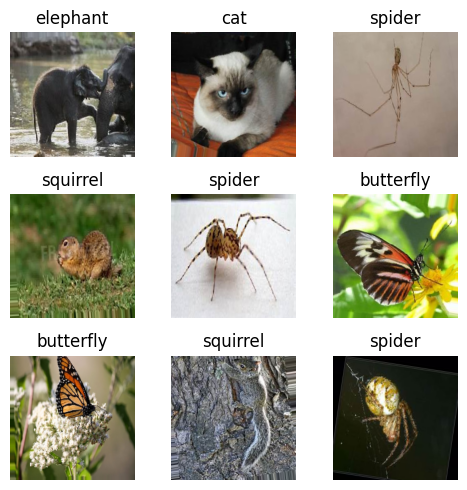

In [10]:

# Translation dictionary
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

# Define the class names in English
class_names = list(translate.values())  # ["dog", "horse", "elephant", ...]

def image(images, labels, class_names, class_indices):
    plt.figure(figsize=(5, 5))  # Create a figure with a larger size
    for i in range(9):  # Loop through 9 images
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid and select the (i+1)th subplot
        plt.imshow(images[i])  # Display the image

        # Get the Italian folder name from class_indices
        italian_name = list(class_indices.keys())[labels[i].argmax()]
        # Translate to English

        english_name = translate[italian_name]
        plt.title(english_name)  # Set the title as the English class name
        plt.axis('off')  # Hide axes
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the entire figure

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot images
image(images, labels, class_names, train_generator.class_indices)


In [11]:
print(class_names)

['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']


##Transfer Learning with VGG16 for Animals-10 Dataset


In [12]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(10, activation='softmax')(x)  # 10 classes in the Animals 10 dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the train and validation generators
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 241s 354ms/step - accuracy: 0.6009 - loss: 1.2203 - val_accuracy: 0.7808 - val_loss: 0.6564
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.7825 - loss: 0.6523 - val_accuracy: 0.8147 - val_loss: 0.5688
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 339ms/step - accuracy: 0.8091 - loss: 0.5666 - val_accuracy: 0.8187 - val_loss: 0.5469
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.8186 - loss: 0.5338 - val_accuracy: 0.8277 - val_loss: 0.5171
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 338ms/step - accuracy: 0.8380 - loss: 0.4814 - val_accuracy: 0.8201 - val_loss: 0.5308
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.8429 - loss: 0.4683 - val_accuracy: 0.8435 - val_loss: 0.4794
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 341ms/step - accuracy: 0.8442 - loss: 0.4615 - val_accuracy: 0.8330 - val_loss: 0.4931
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 338ms/step - accuracy: 0.8444 -

##evaluate VGG16

In [13]:
vgg16_results = model.evaluate(valid_generator)
vgg16_metrics = dict(zip(model.metrics_names, vgg16_results))

print("\n VGG16 Evaluation:")
for metric, value in vgg16_metrics.items():
    print(f"{metric}: {value:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8417 - loss: 0.4819

 VGG16 Evaluation:
loss: 0.4516
compile_metrics: 0.8502


##Transfer Learning with ResNet50V2 for Animals-10 Dataset


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
# Define model
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)  # Prevent overfitting
predictions = Dense(10, activation="softmax")(x)

# Compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", "precision", "recall"]
)

# Summary
model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 24,619,018 (93.91 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

##train ResNet50V2

In [15]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
checkpoints = ModelCheckpoint('resnet50v2_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Store callbacks in a list
callback = [early_stopping, reduce_lr, checkpoints]

# Now you can train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=callback  # This is now correctly defined
)


Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8897 - loss: 0.3815 - precision: 0.9160 - recall: 0.8771
Epoch 1: val_loss improved from inf to 0.16707, saving model to resnet50v2_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 253s 366ms/step - accuracy: 0.8897 - loss: 0.3813 - precision: 0.9160 - recall: 0.8771 - val_accuracy: 0.9496 - val_loss: 0.1671 - val_precision: 0.9615 - val_recall: 0.9424 - learning_rate: 0.0010
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9457 - loss: 0.1644 - precision: 0.9566 - recall: 0.9370
Epoch 2: val_loss did not improve from 0.16707
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 341ms/step - accuracy: 0.9457 - loss: 0.1644 - precision: 0.9566 - recall: 0.9370 - val_accuracy: 0.9496 - val_loss: 0.1761 - val_precision: 0.9589 - val_recall: 0.9426 - learning_rate: 0.0010
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9564 - loss: 0.1307 - precision: 0.9640 - recall: 0.9502
Epoch 3: val_loss did not improve from

##improve ResNet50V2 by using fine-tuning

In [16]:
# Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", "precision", "recall"]
)

# Train for a few more epochs
fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=valid_generator,
    callbacks=callback
)



Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9531 - loss: 0.1486 - precision: 0.9678 - recall: 0.9390
Epoch 1: val_loss improved from 0.16626 to 0.14619, saving model to resnet50v2_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 251s 360ms/step - accuracy: 0.9531 - loss: 0.1485 - precision: 0.9678 - recall: 0.9390 - val_accuracy: 0.9588 - val_loss: 0.1462 - val_precision: 0.9668 - val_recall: 0.9508 - learning_rate: 1.0000e-05
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9668 - loss: 0.1057 - precision: 0.9756 - recall: 0.9595
Epoch 2: val_loss improved from 0.14619 to 0.14054, saving model to resnet50v2_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 224s 342ms/step - accuracy: 0.9668 - loss: 0.1057 - precision: 0.9756 - recall: 0.9595 - val_accuracy: 0.9618 - val_loss: 0.1405 - val_precision: 0.9681 - val_recall: 0.9559 - learning_rate: 1.0000e-05
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9711 - loss: 0.0888 - precision: 0.9785 

##evaluate ResNet50V2

In [29]:
resnet_results = model.evaluate(valid_generator)
resnet_metrics = dict(zip(model.metrics_names, resnet_results))

print("\n ResNet Evaluation:")
for metric, value in resnet_metrics.items():
    print(f"{metric}: {value:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9708 - loss: 0.1255 - precision: 0.9722 - recall: 0.9671

 ResNet Evaluation:
loss: 0.1354
compile_metrics: 0.9687


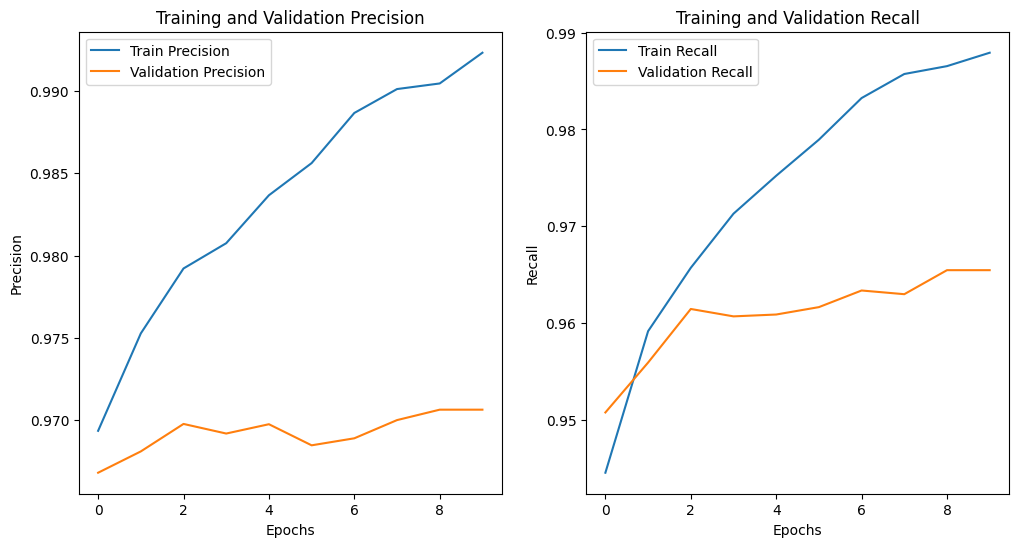

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Precision Plot
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['precision'], label='Train Precision')
plt.plot(history_fine.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Plot
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['recall'], label='Train Recall')
plt.plot(history_fine.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()



plt.show()


##save ResNet50V2 as the best model

In [20]:
model.save("animals10_model.keras")
print("Model saved successfully!")


Model saved successfully!


In [21]:
best_model = load_model("animals10_model.keras")

# Verify by checking the summary
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 42,486,816 (162.07 MB)

 Trainable params: 8,933,898 (34.08 MB)

 Non-trainable params: 15,685,120 (59.83 MB)

 Optimizer params: 17,867,798 (68.16 MB)

## make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


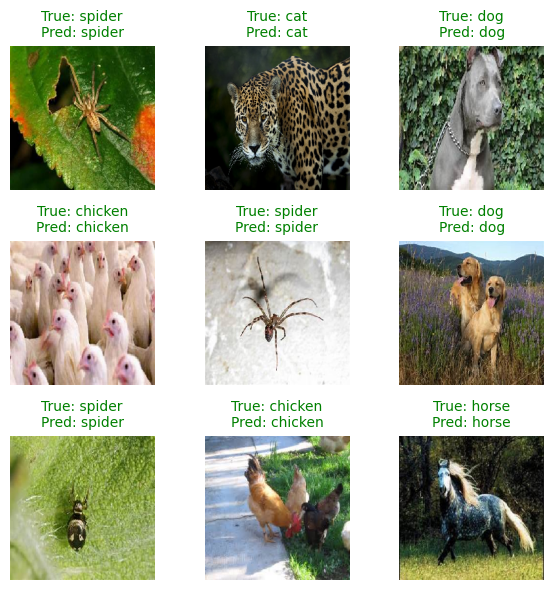

In [22]:

# Function to make predictions and visualize results
def predict_and_visualize(model, generator, class_indices, translate, num_images=9):
    images, true_labels = next(generator)  # Get a batch of images
    predictions = model.predict(images)  # Get model predictions

    plt.figure(figsize=(6, 6))  # Set figure size
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid

        plt.imshow(images[i])  # Show image
        plt.axis("off")  # Hide axes

        # Get true label
        if isinstance(true_labels[i], np.ndarray):  # If one-hot encoded
            true_class_index = np.argmax(true_labels[i])
        else:  # If labels are integers
            true_class_index = true_labels[i]

        true_italian_name = list(class_indices.keys())[true_class_index]
        true_english_name = translate[true_italian_name]

        # Get predicted label
        pred_class_index = np.argmax(predictions[i])
        pred_italian_name = list(class_indices.keys())[pred_class_index]
        pred_english_name = translate[pred_italian_name]

        # Set title with true vs predicted label
        title_color = "green" if true_english_name == pred_english_name else "red"
        plt.title(f"True: {true_english_name}\nPred: {pred_english_name}", fontsize=10, color=title_color)

    plt.tight_layout()  # Adjust spacing
    plt.show()  # Show the images

# Call the function
predict_and_visualize(model, valid_generator, train_generator.class_indices, translate)


## Comparison between the VGG16 & ResNet

In [30]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": vgg16_metrics.keys(),
    "VGG16": vgg16_metrics.values(),
    "ResNet": resnet_metrics.values()
})

print("\nModel Comparison:")
print(comparison_df)



Model Comparison:
            Metric     VGG16    ResNet
0             loss  0.451603  0.135375
1  compile_metrics  0.850219  0.968708


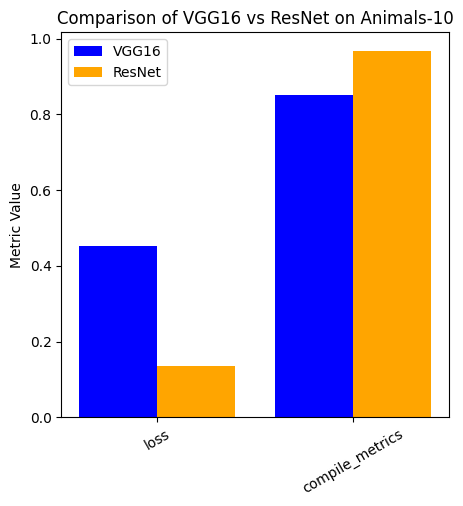

In [31]:
#Visualize the Comparison
metrics = list(vgg16_metrics.keys())
vgg16_values = list(vgg16_metrics.values())
resnet_values = list(resnet_metrics.values())

x = np.arange(len(metrics))

plt.figure(figsize=(5, 5))
plt.bar(x - 0.2, vgg16_values, width=0.4, label="VGG16", color="blue")
plt.bar(x + 0.2, resnet_values, width=0.4, label="ResNet", color="orange")

plt.xticks(x, metrics, rotation=30)
plt.ylabel("Metric Value")
plt.title("Comparison of VGG16 vs ResNet on Animals-10")
plt.legend()
plt.show()
